# Cross validation 

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# my own library
from regression import OLS

x = np.linspace(0, 1, 50) 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 30
k_folds = 7
MSE_test_list = [] 
MSE_train_list = []
MSE_skl_list = []

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.3

x_cent = ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)  
y_cent = ((y - np.mean(y))/np.mean(y)).reshape(-1, 1)  
z_cent = ((z - np.mean(z))/np.mean(z)).reshape(-1, 1)

# Cross validation:
# shuffle data:
order = np.arange(x_cent.shape[0]) #number of data points
np.random.shuffle(order)
x_cent_ = x_cent[order].ravel().reshape(-1,1)
y_cent_ = y_cent[order].ravel().reshape(-1,1)
z_cent_ = z_cent[order].ravel().reshape(-1,1)
xyz_shuffle = np.hstack([x_cent_, y_cent_, z_cent_])
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for k in tqdm.tqdm(range(k_folds)): 
    MSE_test = []
    MSE_train = []
    MSE_skl = []
    
    # extract folds
    xyz_test = xyz_folds[k]
    xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]) # skip k-th fold

    xy_train = xyz_train[:, 0:2]
    z_train = xyz_train[:, 2].reshape(-1, 1)
    xy_test = xyz_test[:, 0:2]
    z_test = xyz_test[:, 2].reshape(-1, 1)    
    
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), LinearRegression(fit_intercept=False))
        model = OLS(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg)
        
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) #tester modellen på test
        MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel())) # tester på fit
        
        #sklearn:
        z_pred = model_skl.fit(xy_train, z_train.reshape(-1, 1)).predict(xy_test)
        MSE_skl.append(np.mean((z_pred.ravel() - z_test.ravel())**2)) # tester modellen mot
        
    MSE_test_list.append(MSE_test) 
    MSE_train_list.append(MSE_train)
    MSE_skl_list.append(MSE_skl)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)
MSE_skl_list = np.array(MSE_skl_list)

#study average values
test_pol_avrg = np.mean(MSE_test_list, axis=0) 
train_pol_avrg = np.mean(MSE_train_list, axis=0)
test_skl_avrg = np.mean(MSE_skl_list, axis=0)

100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


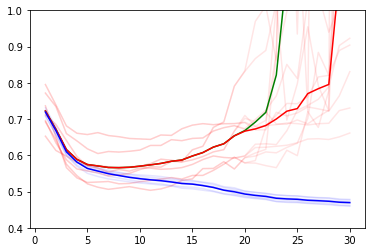

In [39]:
for i in range(len(MSE_test_list)):
    plt.plot(range(1, len(MSE_test)+1), MSE_test_list[i], 'r', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_train_list[i], 'b', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_skl_list[i], 'r', alpha=0.1)

plt.plot(range(1, len(MSE_test)+1), test_skl_avrg, 'g')
plt.plot(range(1, len(MSE_test)+1), test_pol_avrg, 'r')
plt.plot(range(1, len(MSE_train)+1), train_pol_avrg, 'b')

plt.ylim(0.4, 1)
plt.show()
# Obs

Notes:
- SK-Learn and my own implementation of seems to diverge from each other for polynomials above order 23. This is the same as with the bootstrap method. 
- The optimum seems to be in the same place as in the previous excercise, p=5 with MSE=0,55. Thus Cross-Validation and bootstrap seems to estimate the same expected values for MSE
- I did not do any analysis of beta
- Not scaling data causes a lower MSE, but since the MSE is relative to scaled dataset it does not change the error.. 
- Not scaling data seems to make sklearn and my own OLS solver diverge from each other sooner than if the data is scaled. It does not matter if I use normaliation or standardization to scale data. 

In [40]:
#implementation of k-fold splitter: 
xyz_folds = [[] for _ in range(k_folds)] # make list
for data_nr in range(xyz_shuffle.shape[0]): # hand observations to each group, then repeat
    fold_nr = data_nr % (k_folds) # repeat
    xyz_folds[fold_nr].append(xyz_shuffle[data_nr, :])

xyz_folds = np.array(xyz_folds, dtype=object) # object since last groups is not filled